In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import datetime
import os
import tqdm
import time
import glob
import pandas as pd
import xarray as xr
from dateutil.relativedelta import relativedelta
from matplotlib.colors import LogNorm

os.chdir('/Users/zach/Documents/Quadtree-MPNNLSTM')

from model.graph_functions import unflatten
from model.utils import normalize, int_to_datetime
from model.mpnnlstm import NextFramePredictorS2S
from model.seq2seq import Seq2Seq
from model.graph_functions import create_static_heterogeneous_graph, create_static_homogeneous_graph

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from ice_dataset import IceDataset

In [30]:
device = torch.device('cpu')

# Defaults
convolution_type = 'TransformerConv'

training_years = range(2010, 2011)
# training_years = range(2002, 2013)
# x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf', 'usi', 'vsi', 'sithick']
x_vars = ['siconc', 't2m', 'v10', 'u10', 'sshf']
y_vars = ['siconc']
input_features = len(x_vars)
# input_timesteps = 10
# output_timesteps= 90
input_timesteps = 3
output_timesteps= 45

binary=False

# Set threshold 
thresh = -np.inf

# Arguments passed to Seq2Seq constructor
# model_kwargs = dict(
#     hidden_size=32,
#     dropout=0.1,
#     n_layers=1,
#     dummy=False,
#     n_conv_layers=3,
#     rnn_type='LSTM',
#     convolution_type=convolution_type,
# )

model_kwargs = dict(
    hidden_size=16,
    dropout=0.1,
    n_layers=1,
    n_conv_layers=2,
    dummy=False,
    convolution_type=convolution_type,
    rnn_type='LSTM',
)

month = 6
ds = xr.open_mfdataset(glob.glob('/Users/zach/Documents/Quadtree-MPNNLSTM/data/ERA5_GLORYS/*.nc'))
mask = np.isnan(ds.siconc.isel(time=0)).values

climatology = ds[y_vars].fillna(0).groupby('time.dayofyear').mean('time', skipna=True).to_array().values
climatology = torch.tensor(np.nan_to_num(climatology)).to(device)

graph_structure = create_static_heterogeneous_graph(mask.shape, 4, mask, use_edge_attrs=True, resolution=1/12, device=device)
# graph_structure = create_static_homogeneous_graph(mask.shape, 4, mask, use_edge_attrs=True, resolution=0.25, device=device)

data_val = IceDataset(ds, [2015], month, input_timesteps, output_timesteps, x_vars, y_vars)

In [4]:
experiment_name = f'M{str(month)}_Y{training_years[0]}_Y{training_years[-1]}_I{input_timesteps}O{output_timesteps}'

model = NextFramePredictorS2S(
    thresh=thresh,
    experiment_name=experiment_name,
    input_features=input_features,
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    device=device,
    binary=binary,
    debug=False, 
    model_kwargs=model_kwargs)

results_dir = f'results/ice_results_profile/'

model.load(results_dir)

class Sampler(SubsetRandomSampler):
    def __init__(self, indices):
        super().__init__(indices[:1])

In [162]:
xs = []
att_maps_to = []
att_maps_from = []
for i in tqdm.tqdm(range(1)):
    loader_val = DataLoader(data_val, batch_size=1, shuffle=False, sampler=Sampler([i]))
    model.predict(loader_val, climatology, mask=mask, graph_structure=graph_structure)
    with open(f'scratch/attention_maps_0.npy', 'rb') as f:
        alpha = np.load(f)
        x = np.load(f)
        att_map_from = np.load(f)
        att_map_to = np.load(f)
        
        xs.append(x)
        att_maps_from.append(att_map_from)
        att_maps_to.append(att_map_to)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 199.05it/s]


In [96]:
att_map_from_i = torch.zeros(size=(x.shape[0], 1), dtype=torch.float32)
n, c = torch.unique(graph_structure['edge_index'][0], return_counts=True)
for from_node, count_ in zip(n, c):
    att_map_from_i[from_node] = count_
    
np.unique(att_map_from_i, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 17., 18., 20.], dtype=float32),
 array([   1,   17,   75,  215,  668, 1289, 1471, 2388, 1313, 1283,  356,
         121,  128,   45,   32,   15,    2,    2,    2]))

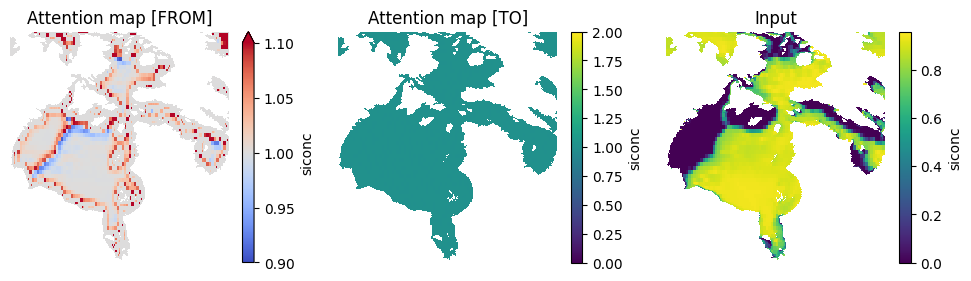

In [98]:
tmp = xr.zeros_like(ds.isel(time=0).siconc)

i = 0
fns = []
for x, att_map_from, att_map_to in zip(xs, att_maps_from, att_maps_to):
    
    att_map_from[np.where(att_map_from_i!=9)] = 1
    
    att_map_from = unflatten(torch.Tensor(np.nan_to_num(att_map_from)), graph_structure['mapping'], mask.shape)
    att_map_to = unflatten(torch.Tensor(np.nan_to_num(att_map_to)), graph_structure['mapping'], mask.shape)
    x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    tmp = xr.zeros_like(ds.isel(time=0).siconc)

    tmp.values = att_map_from[..., 0]
    tmp.where(~mask).plot(ax=axs[0], cmap='coolwarm', center=1, vmax=0.1, vmin=-0.1)

    tmp.values = att_map_to[..., 0]
    tmp.where(~mask).plot(ax=axs[1], vmin=0, vmax=2)

    tmp.values = x[..., 0]
    tmp.where(~mask).plot(ax=axs[2])

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    axs[0].set_title('Attention map [FROM]')
    axs[1].set_title('Attention map [TO]')
    axs[2].set_title('Input')
        
    fn = f'scratch/att_gif/{i}.png'
    plt.savefig(fn)
    fns.append(fn)
    
    plt.show()
    
    i += 1

    
# from PIL import Image
# frames = []
# for fn in fns:
#     new_frame = Image.open(fn)
#     frames.append(new_frame)
            
# frames[0].save(f'scratch/att_gif/att_map.gif',
#             format='GIF',
#             append_images=frames[1:],
#             save_all=True,
#             duration=300,
#             loop=0)

# for fn in fns:
#     os.remove(fn)

In [184]:
angles = np.array(graph_structure['edge_attrs'][..., 0] * (2*np.pi)).flatten()
angles.shape

alpha_x = np.array(alpha).flatten() * np.cos(angles)
alpha_y = np.array(alpha).flatten() * np.sin(angles)

from_nodes = graph_structure['edge_index'][1]

att_map_from = torch.zeros(size=(x.shape[0], 2), dtype=torch.float32)
for a_x, a_y, from_node in zip(alpha_x, alpha_y, from_nodes):
    att_map_from[from_node][0] += a_x
    att_map_from[from_node][1] += a_y
    
magn = np.array(np.sqrt(att_map_from[:, 0]**2 + att_map_from[:, 1]**2))

# att_map_from = np.clip(att_map_from, -0.15, 0.15)
# att_map_from = np.where(np.array([magn, magn]).T>0.2, np.nan, att_map_from)

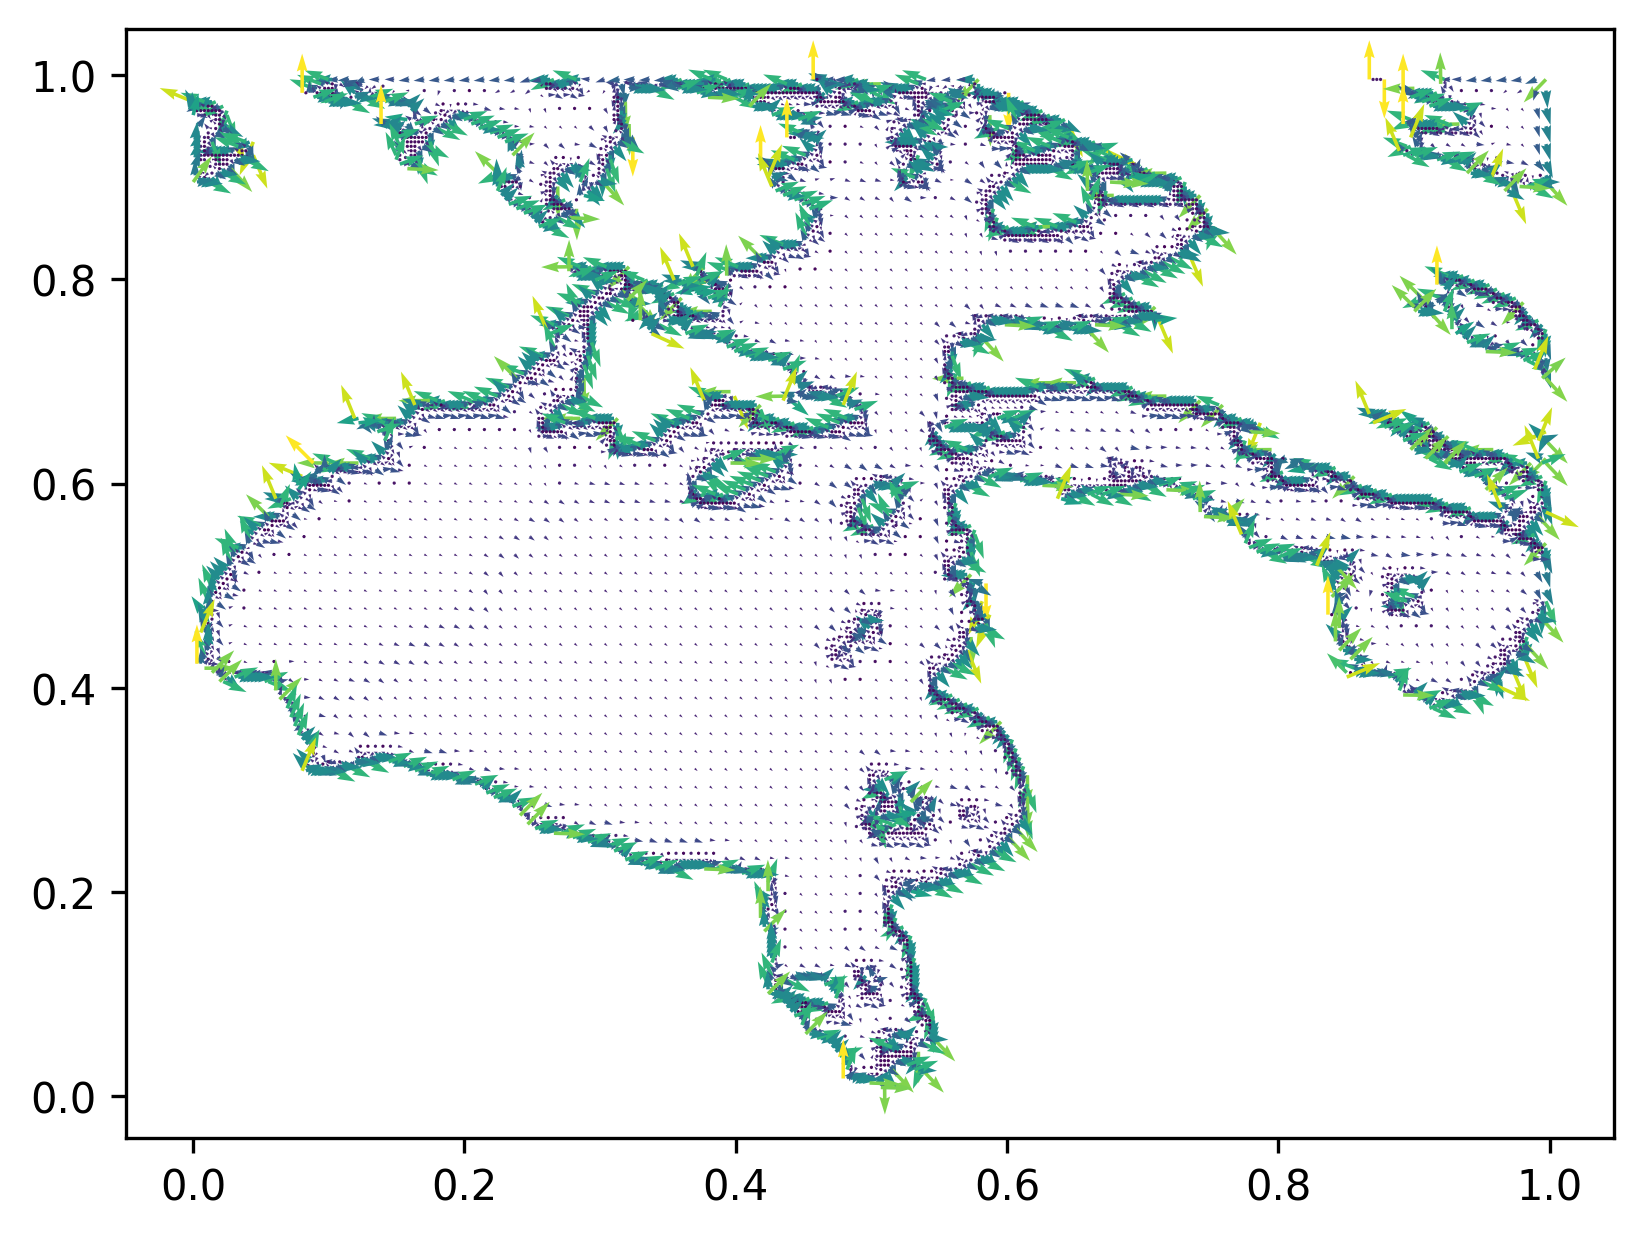

In [185]:
plt.figure(dpi=300)
plt.quiver(xx, yy, att_map_from[:, 0], att_map_from[:, 1], magn)

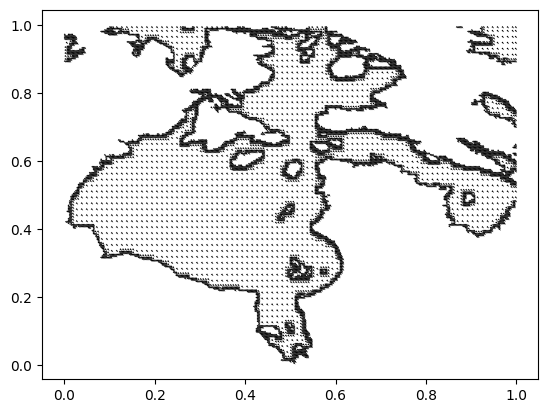

In [32]:
xx = graph_structure['data'][0, ..., -3]
yy = graph_structure['data'][0, ..., -2]

x.shape

plt.quiver(xx,yy,[1],[-1])
plt.show()

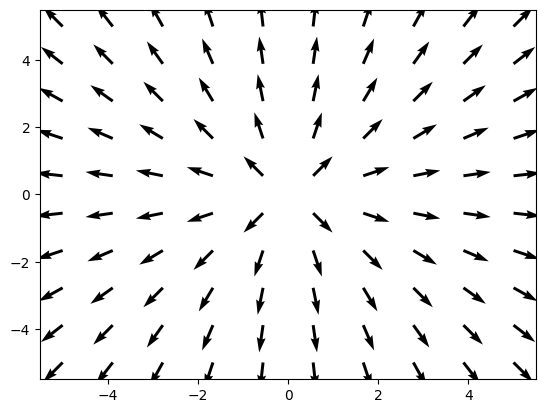

In [99]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))

u = x/np.sqrt(x**2 + y**2)
v = y/np.sqrt(x**2 + y**2)

plt.quiver(x,y,u,v)
plt.show()

In [171]:
att_var.max()

tensor(0.0008)

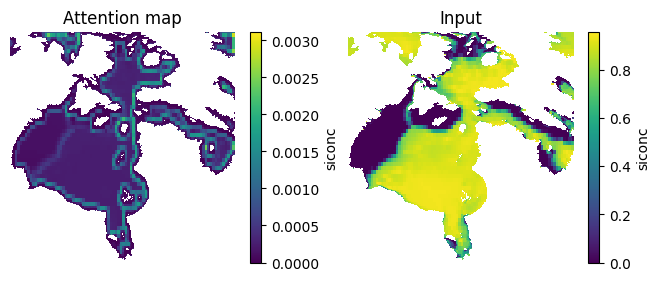

In [177]:
to_nodes = graph_structure['edge_index'][1]

att_map_to_i = torch.zeros(size=(x.shape[0], 1), dtype=torch.float32)
att_map_to = [[] for _ in range(x.shape[0])]

for a, to_node in zip(alpha, to_nodes):
    att_map_to[to_node].append(a.item())
    att_map_to_i[to_node] += 1
    
# att_var = [np.var(np.array(a)/float(i)) for a, i in zip(att_map_to, att_map_to_i)]
att_var = [np.var(a) for a in att_map_to]
att_var = unflatten(torch.Tensor(np.nan_to_num(att_var)), graph_structure['mapping'], mask.shape)

input_ = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_var.T
tmp.where(~mask).plot(ax=axs[0])

tmp.values = input_[..., 0]
tmp.where(~mask).plot(ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Attention map')
axs[1].set_title('Input')

plt.show()

In [75]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Range1d
from bokeh.models import HoverTool
from bokeh.transform import linear_cmap
from bokeh.palettes import PiYG
from bokeh.models import LinearColorMapper, WheelZoomTool

output_notebook()

image = np.where(mask, np.nan, np.array(att_map_from[..., 0]))

color_mapper = LinearColorMapper(palette=PiYG[9], low=-1, high=1)


p = figure(toolbar_location=None, tools='zoom_in,zoom_out,reset,pan,xwheel_zoom')
p.image(image=[image], x=0, y=0, dw=image.shape[1], dh=image.shape[0])#, palette=PiYG[9])

hover_tool = HoverTool(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], mode="mouse")
p.add_tools(WheelZoomTool(dimensions='both'))
p.add_tools(hover_tool)

show(p)

Loading BokehJS ...

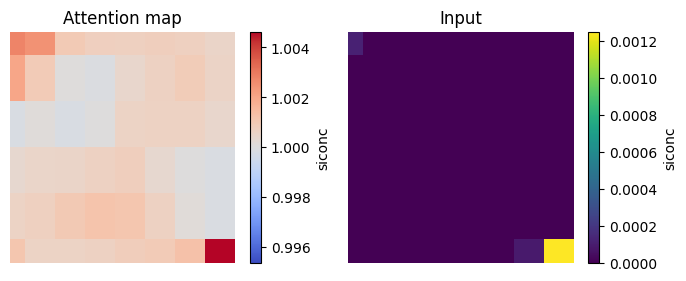

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_map_from[..., 0]
tmp.where(~mask).isel(latitude=slice(110, 130), longitude=slice(30, 60)).plot(ax=axs[0], cmap='coolwarm', center=1)

tmp.values = x[..., 0]
tmp.where(~mask).isel(latitude=slice(110, 130), longitude=slice(30, 60)).plot(ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Attention map')
axs[1].set_title('Input')

plt.show()

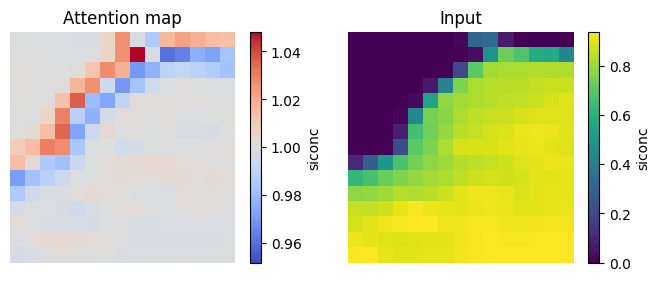

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_map_from[..., 0]
tmp.where(~mask).isel(latitude=slice(80, 140), longitude=slice(60, 120)).plot(ax=axs[0], cmap='coolwarm', center=1)

tmp.values = x[..., 0]
tmp.where(~mask).isel(latitude=slice(80, 140), longitude=slice(60, 120)).plot(ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Attention map')
axs[1].set_title('Input')

plt.show()

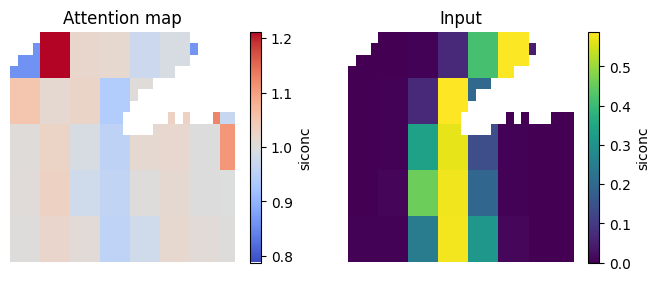

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_map_from[..., 0]
tmp.where(~mask).isel(latitude=slice(140, 160), longitude=slice(80, 110)).plot(ax=axs[0], cmap='coolwarm', center=1)

tmp.values = x[..., 0]
tmp.where(~mask).isel(latitude=slice(140, 160), longitude=slice(80, 110)).plot(ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Attention map')
axs[1].set_title('Input')

plt.show()

In [9]:
from model.graph_functions import unflatten

i = 15

loader_val = DataLoader(data_val, batch_size=1, shuffle=False, sampler=Sampler([i]))
_ = model.predict(loader_val, climatology, mask=mask, graph_structure=graph_structure)

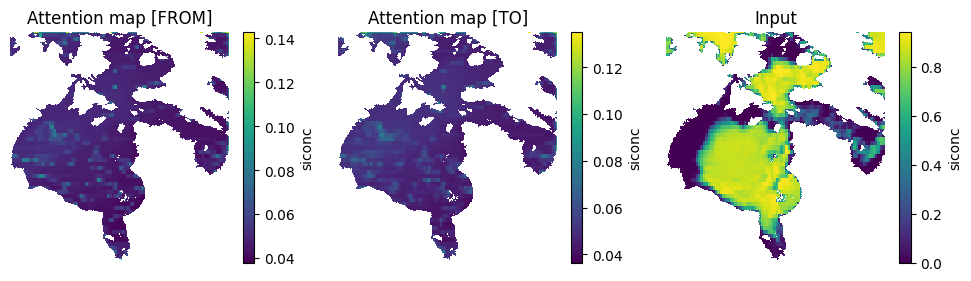

In [6]:
for i in range(1):
    with open(f'scratch/attention_maps_{i}.npy', 'rb') as f:
        alpha = np.load(f)
        x = np.load(f)
        att_map_from = np.load(f)
        att_map_to = np.load(f)

    att_map_from = unflatten(torch.Tensor(np.nan_to_num(att_map_from)), graph_structure['mapping'], mask.shape)
    att_map_to = unflatten(torch.Tensor(np.nan_to_num(att_map_to)), graph_structure['mapping'], mask.shape)
    x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    tmp = xr.zeros_like(ds.isel(time=0).siconc)

    tmp.values = att_map_from[..., 0]
    tmp.where(~mask).plot(ax=axs[0])

    tmp.values = att_map_to[..., 0]
    tmp.where(~mask).plot(ax=axs[1])

    tmp.values = x[..., 0]
    tmp.where(~mask).plot(ax=axs[2])

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    axs[0].set_title('Attention map [FROM]')
    axs[1].set_title('Attention map [TO]')
    axs[2].set_title('Input')
    plt.show()

Text(0.5, 1.0, 'Sea ice concentration')

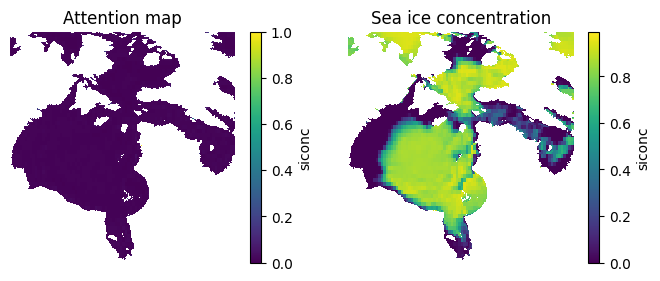

In [165]:
alpha = []
x = []
att_map_from = []
att_map_to = []
for i in range(3):
    with open(f'scratch/attention_maps_{i}.npy', 'rb') as f:
        alpha.append(np.load(f))
        x.append(np.load(f)[:, [0]])
        att_map_from.append(np.load(f))
        att_map_to.append(np.load(f))
        
    
att_map_from = np.array(att_map_from)
att_map_to = np.array(att_map_to)
x = np.array(x)

map_ = np.zeros(graph_structure['graph_nodes'].max()+1)

for n in graph_structure['graph_nodes']:
    
    traj = []
    idx = np.where(graph_structure['edge_index'][0]==n)[0]
    # get values
    neighbors = graph_structure['edge_index'][1][idx]
    for ii, nn in zip(idx, neighbors):
        idxx = np.where(graph_structure['edge_index'][0]==nn)[0]
        # get values
        neighbors_2 = graph_structure['edge_index'][1][idxx]
        for iii, nnn in zip(idxx, neighbors_2):
            idxxx = np.where(graph_structure['edge_index'][0]==nnn)[0]
            # get values
            neighbors_3 = graph_structure['edge_index'][1][idxxx]
            
            for iiii in idxxx:
                traj.append((ii, iii, iiii))
            
    for t in traj:
        map_[n] += (alpha[0][t[0]] * alpha[1][t[1]] * alpha[2][t[2]])
    
    if len(traj) != 0:
        map_[n] = map_[n] / len(traj)

map_ = unflatten(torch.Tensor(np.nan_to_num(map_)), graph_structure['mapping'], mask.shape)
x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)

tmp = xr.zeros_like(ds.isel(time=0).siconc)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

tmp.values = map_.T
tmp.where(~mask).plot(ax=axs[0])

tmp.values = x[0, ..., 0]
tmp.where(~mask).plot(ax=axs[1])

axs[0].axis('off')
axs[1].axis('off')

axs[0].set_title('Attention map')
axs[1].set_title('Sea ice concentration')

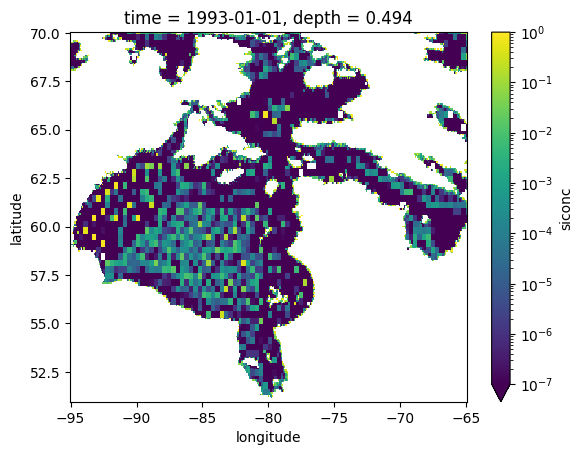

In [132]:
alpha = []
x = []
att_map_from = []
att_map_to = []
for i in range(3):
    with open(f'scratch/attention_maps_{i}.npy', 'rb') as f:
        alpha.append(np.load(f))
        x.append(np.load(f)[:, [0]])
        att_map_from.append(np.load(f))
        att_map_to.append(np.load(f))
        
    
att_map_from = np.array(att_map_from)
att_map_to = np.array(att_map_to)
x = np.array(x)

map_ = np.ndarray(graph_structure['graph_nodes'].max()+1)
for n in graph_structure['graph_nodes']:
    idx = np.where(graph_structure['edge_index'][0]==n)[0]
    for i in range(3):
        map_[n] = np.prod(alpha[i][idx])

map_ = unflatten(torch.Tensor(np.nan_to_num(map_)), graph_structure['mapping'], mask.shape)
x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)

tmp = xr.zeros_like(ds.isel(time=0).siconc)
tmp.values = map_.T
tmp.where(~mask).plot(norm=LogNorm(vmin=0.0000001, vmax=1))
# tmp.where(~mask).plot()

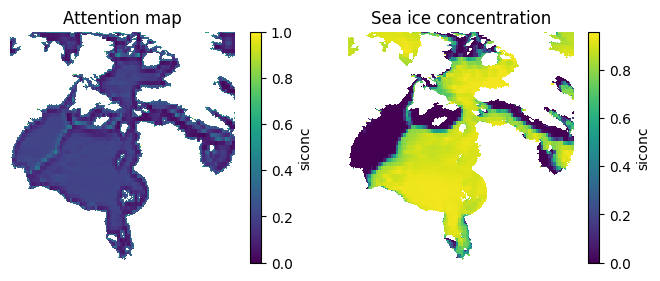

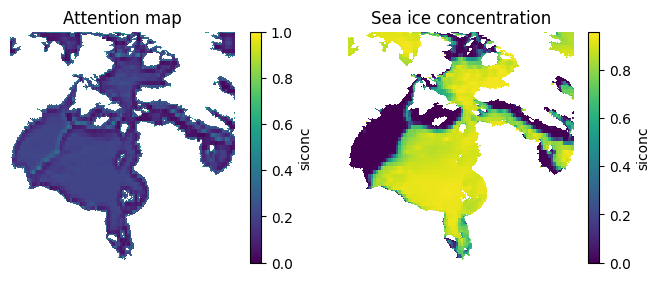

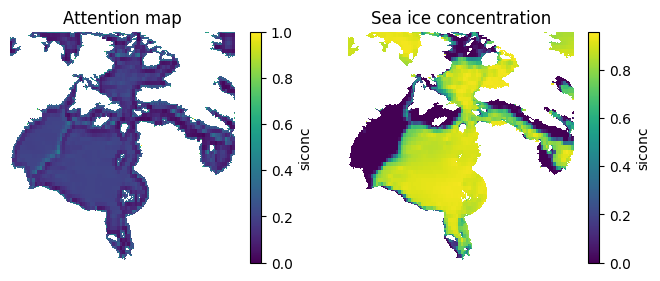

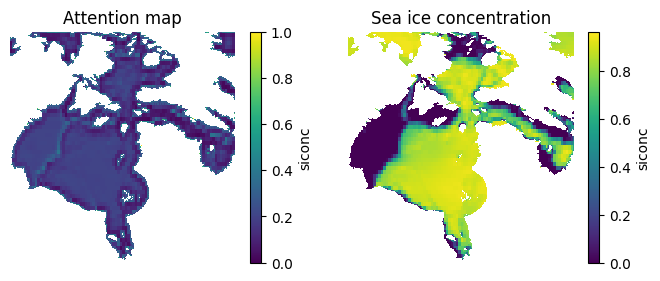

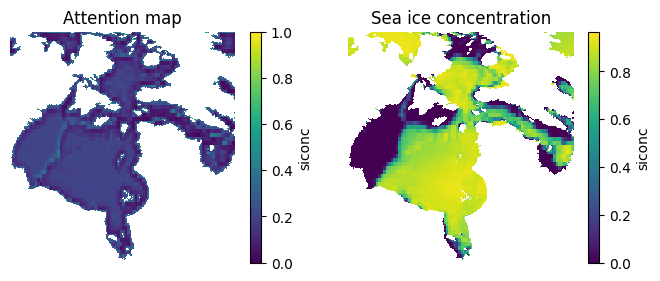

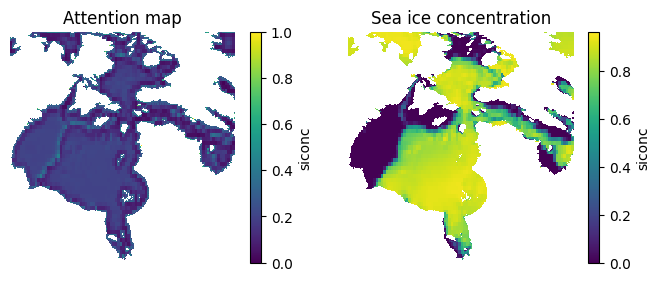

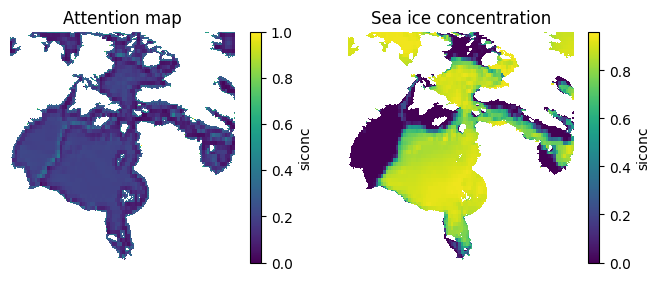

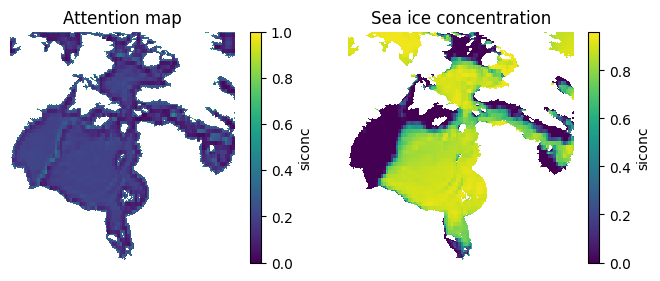

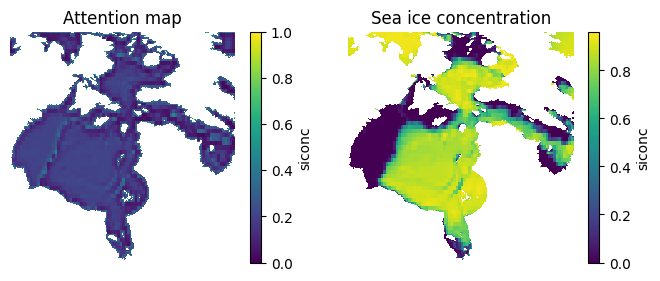

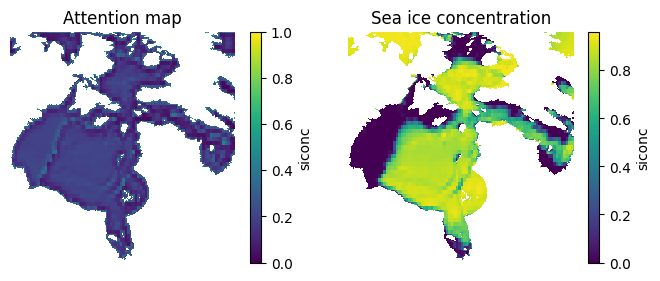

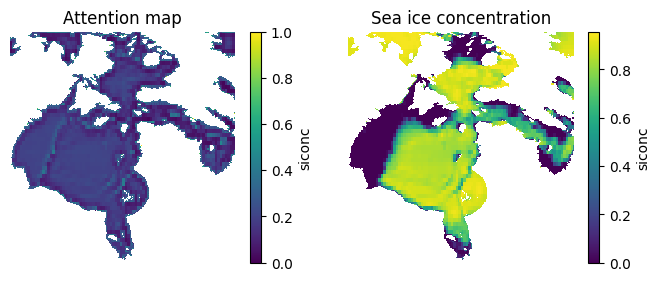

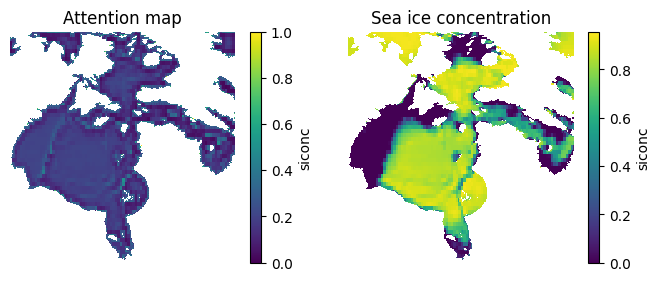

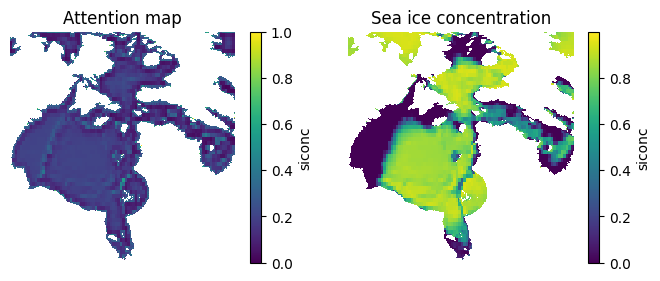

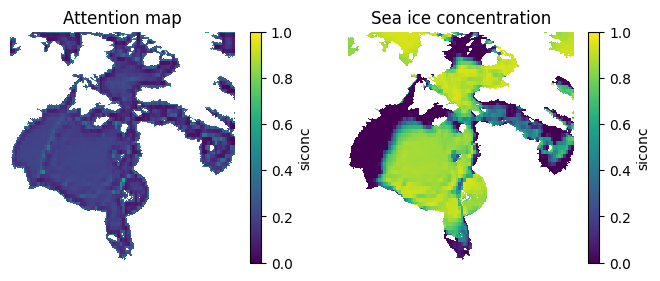

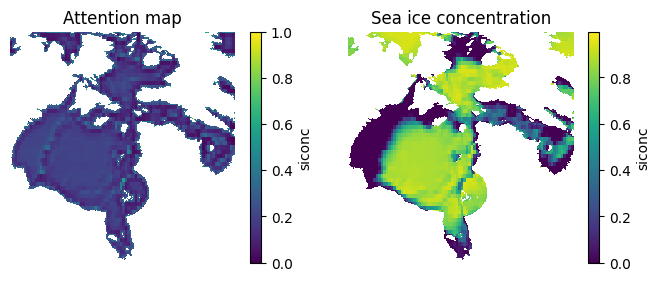

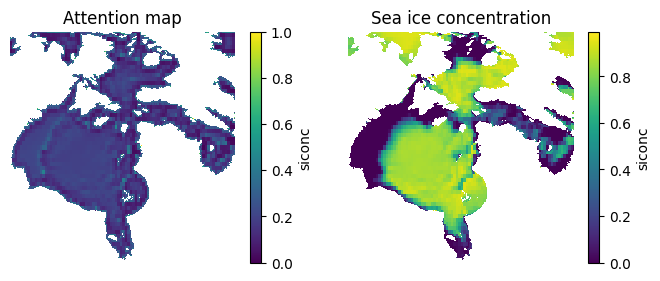

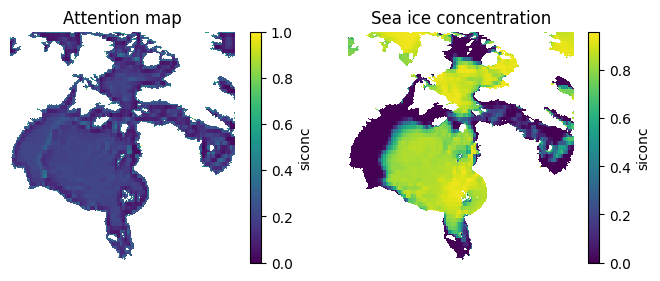

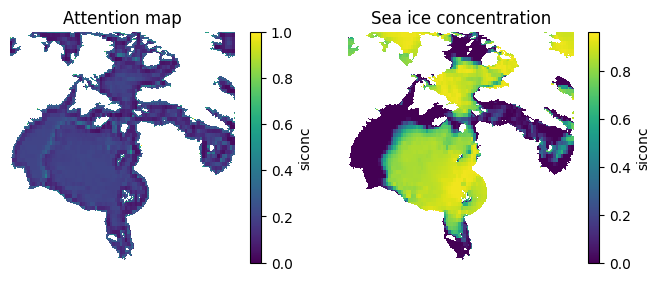

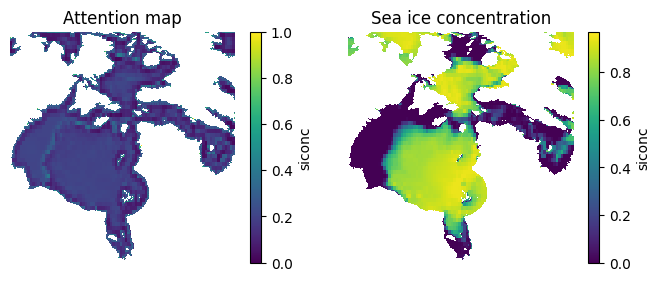

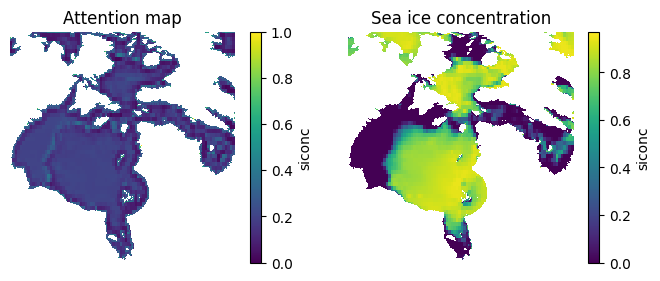

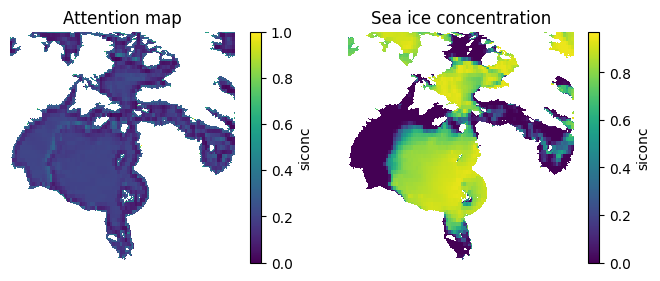

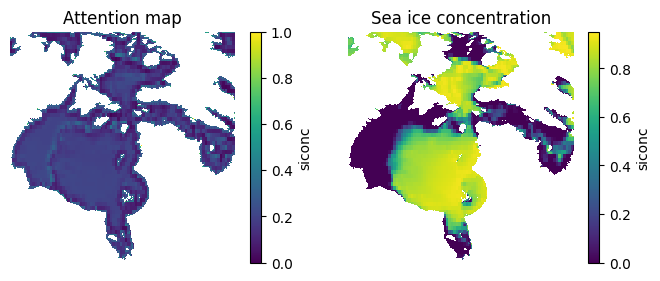

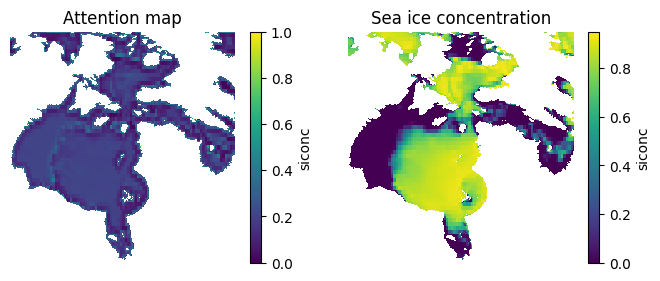

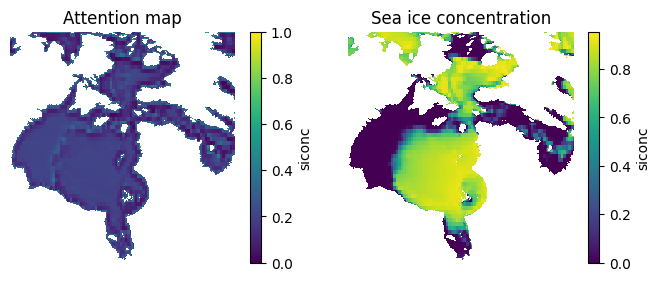

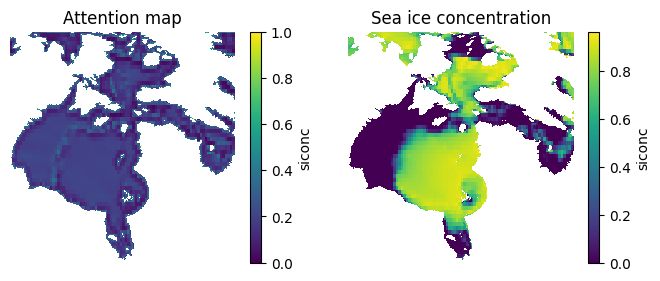

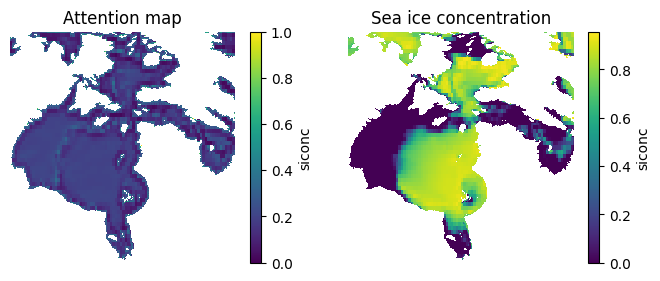

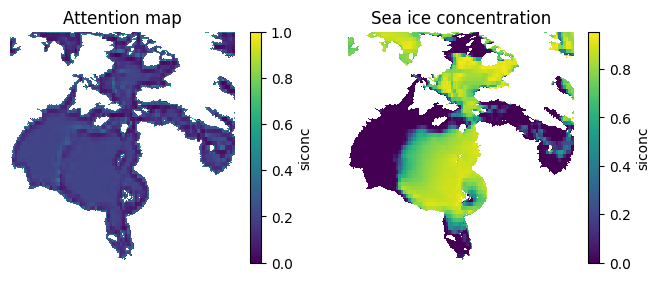

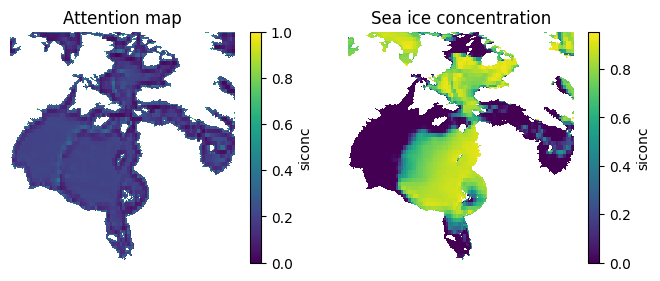

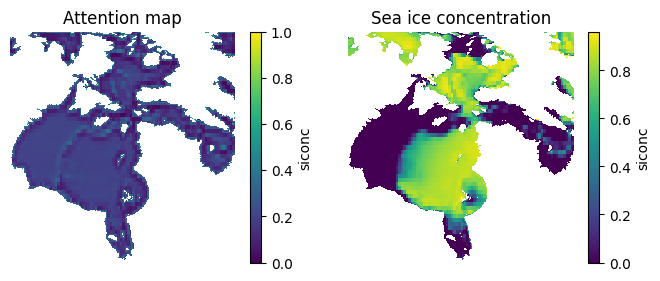

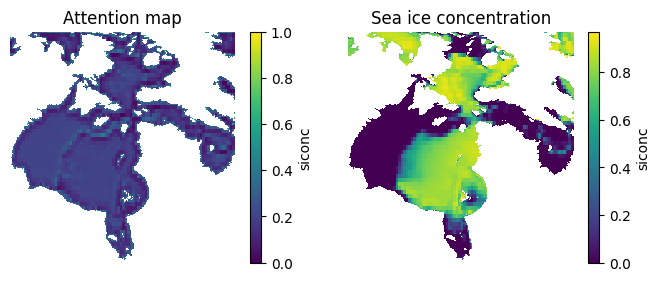

In [24]:
tmp = xr.zeros_like(ds.isel(time=0).siconc)

i = 0
fns = []
for x, att_map in zip(xs, att_maps):
    
    att_map = unflatten(torch.Tensor(np.nan_to_num(att_map)), graph_structure['mapping'], mask.shape)
    x = unflatten(torch.Tensor(x), graph_structure['mapping'], mask.shape)
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))

    tmp.values = att_map[..., 0]
    tmp.where(~mask).plot(ax=axs[0])

    tmp.values = x[..., 0]
    tmp.where(~mask).plot(ax=axs[1])
    
    axs[0].axis('off')
    axs[1].axis('off')
    
    axs[0].set_title('Attention map')
    axs[1].set_title('Sea ice concentration')
        
    fn = f'scratch/att_gif/{i}.png'
    plt.savefig(fn)
    fns.append(fn)
    
    plt.show()
    
    i += 1
    
    
from PIL import Image
frames = []
for fn in fns:
    new_frame = Image.open(fn)
    frames.append(new_frame)
            
frames[0].save(f'scratch/att_gif/att_map.gif',
            format='GIF',
            append_images=frames[1:],
            save_all=True,
            duration=300,
            loop=0)

for fn in fns:
    os.remove(fn)

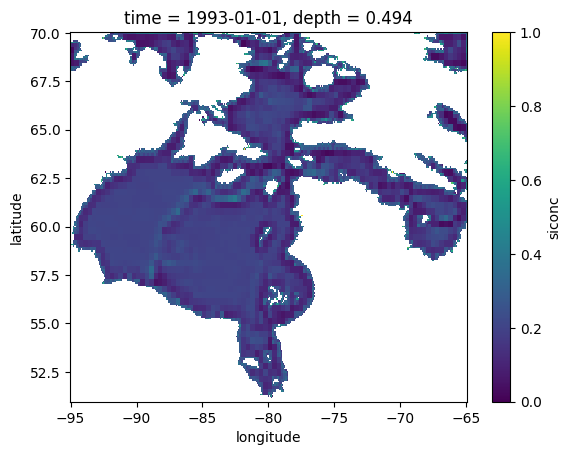

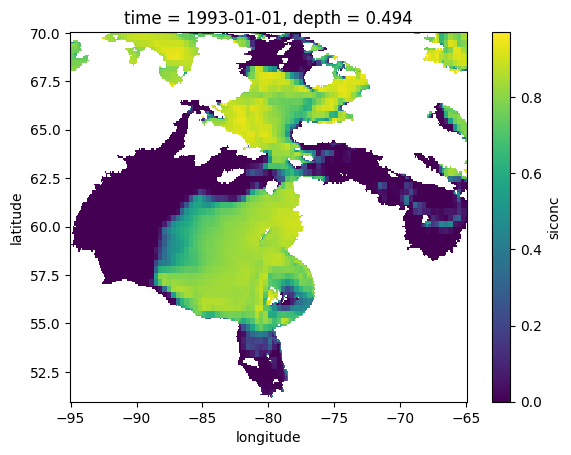

In [25]:
tmp.values = att_map[..., 0]
tmp.where(~mask).plot()
plt.show()

tmp.values = x[..., 0]
tmp.where(~mask).plot()
plt.show()

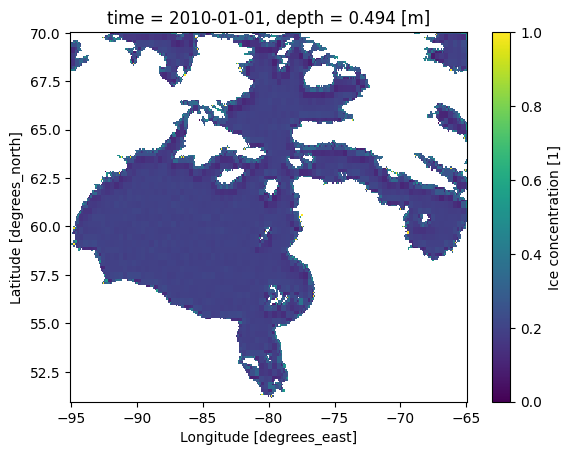

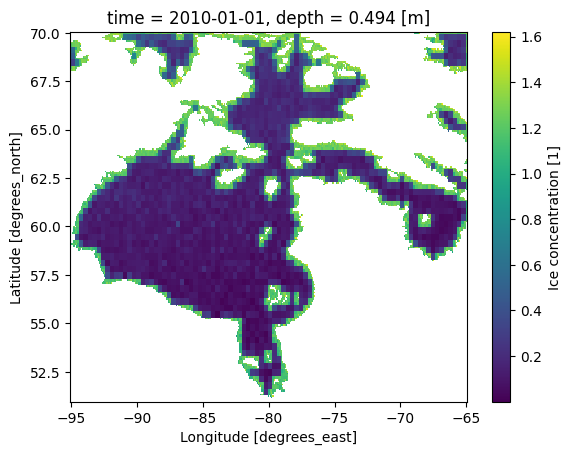

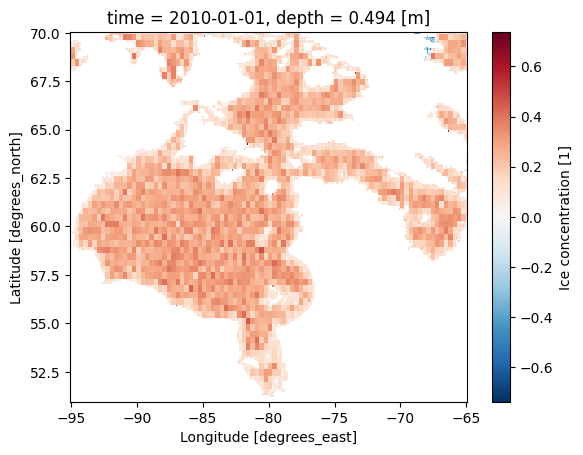

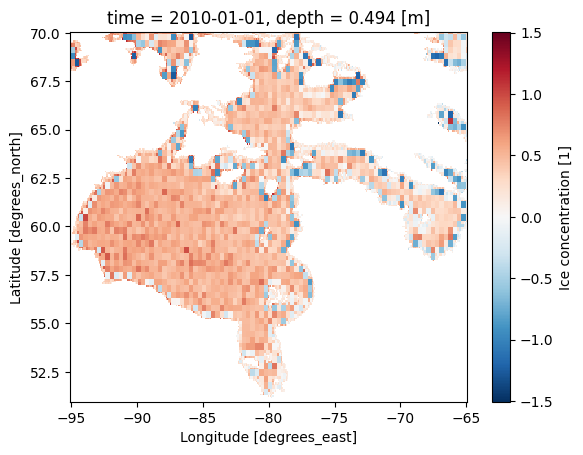

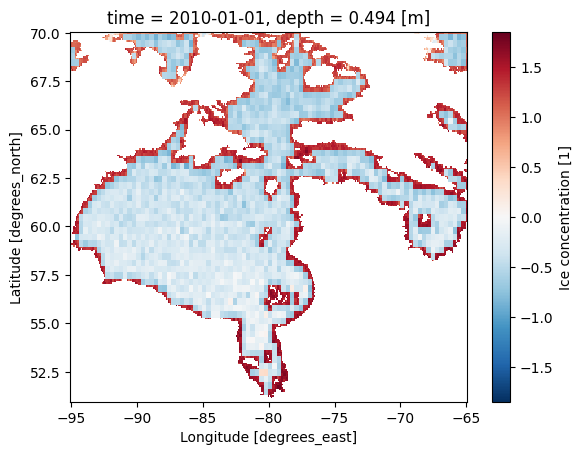

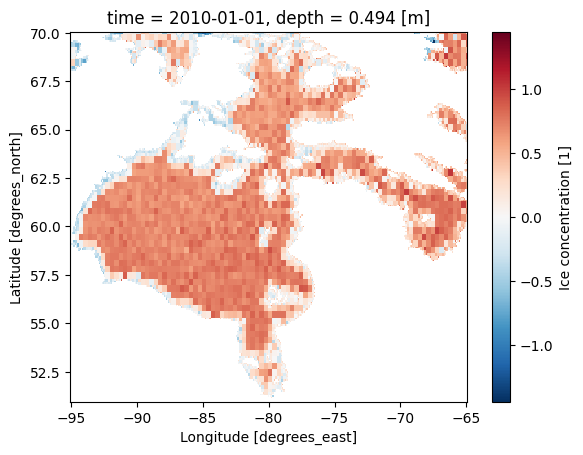

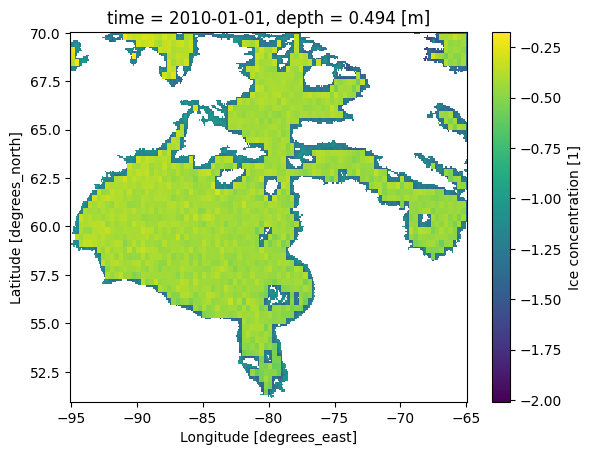

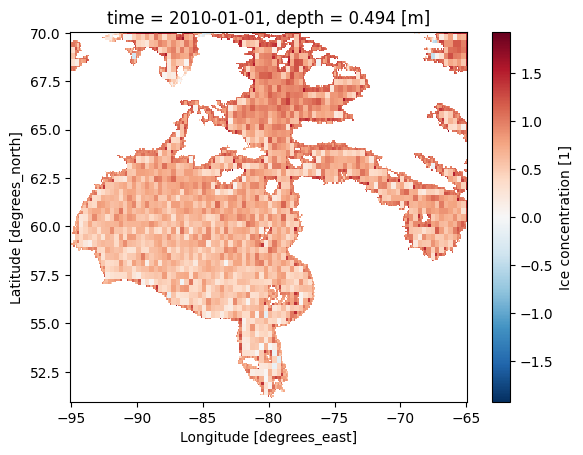

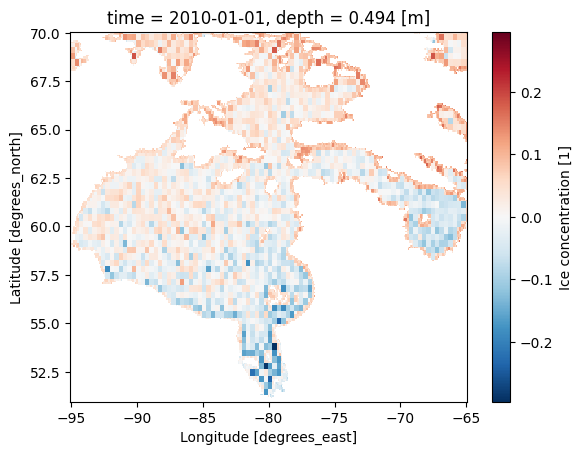

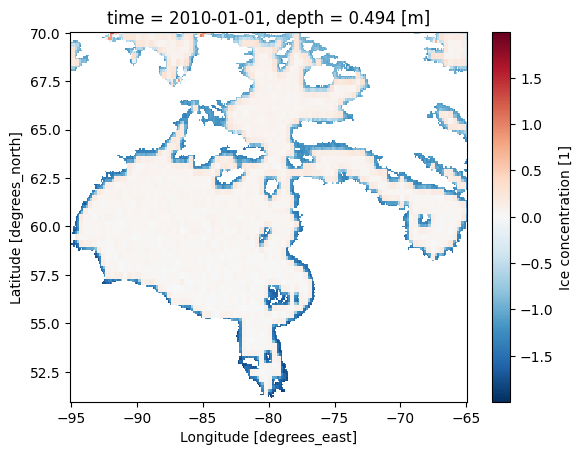

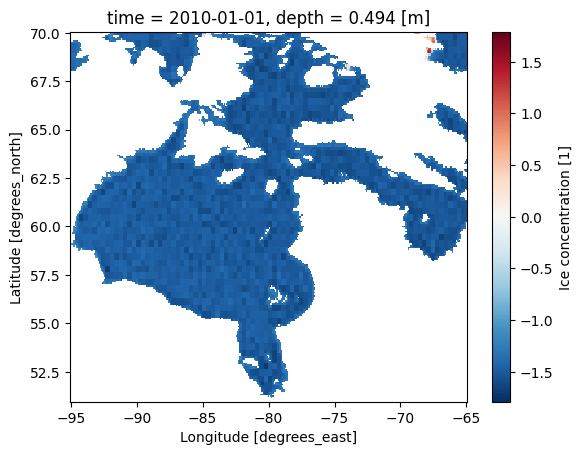

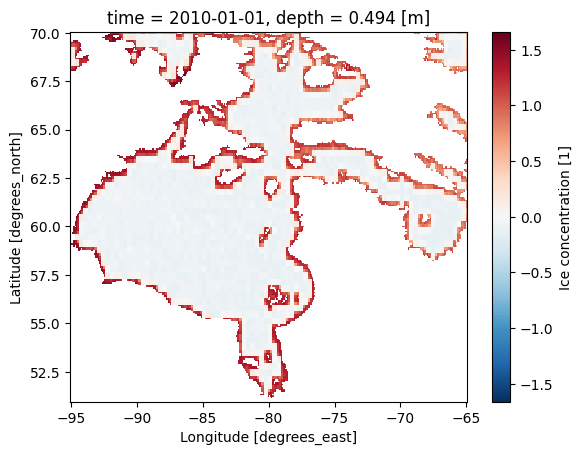

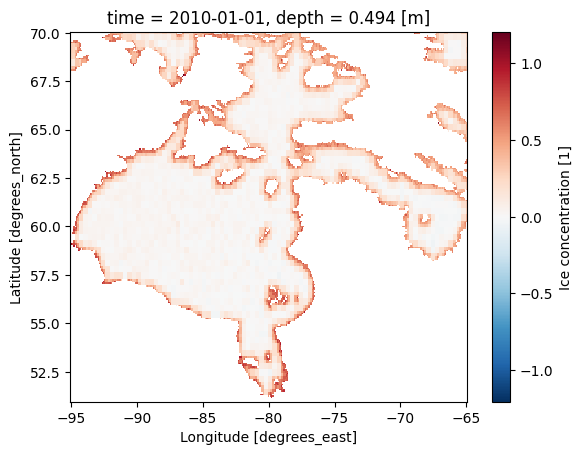

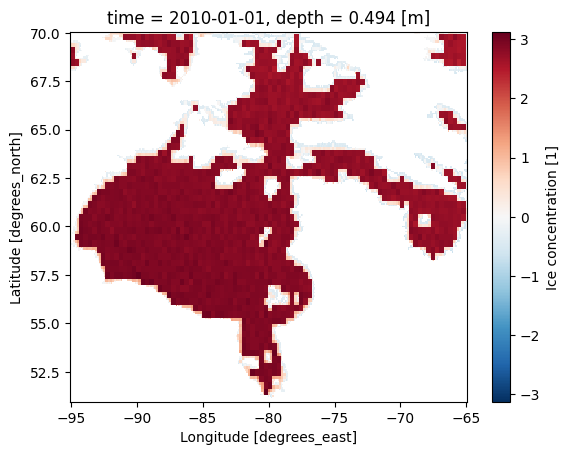

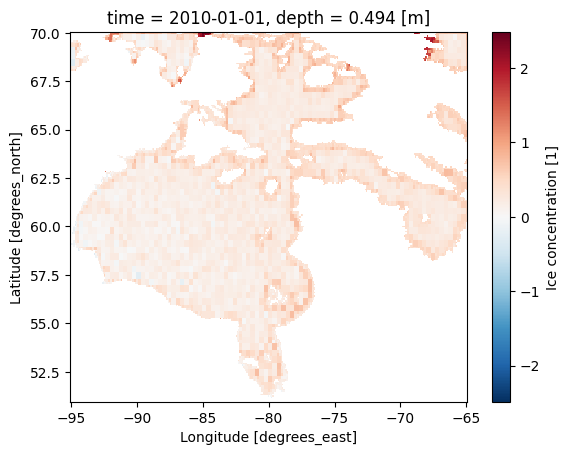

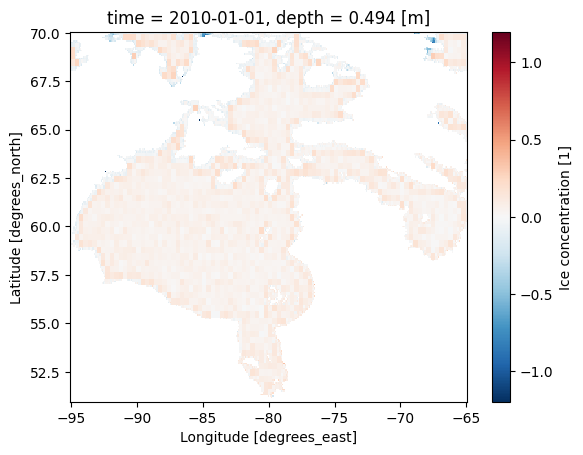

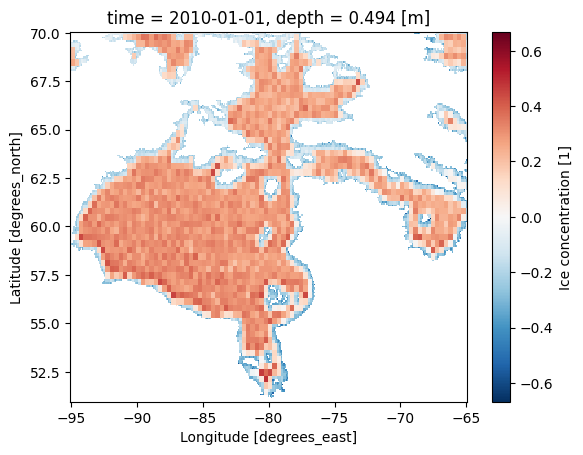

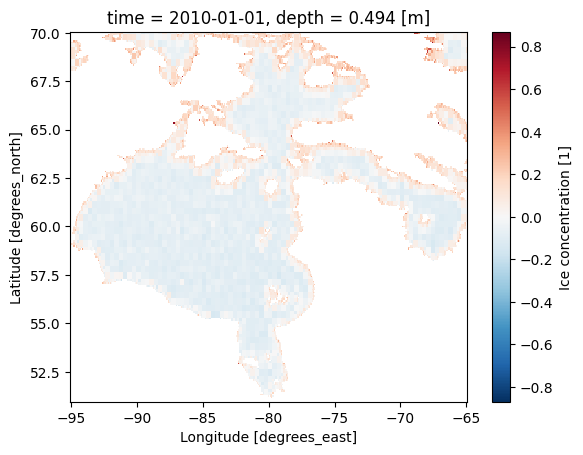

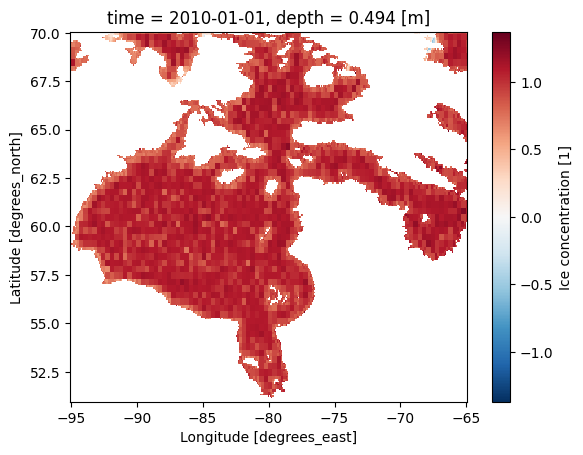

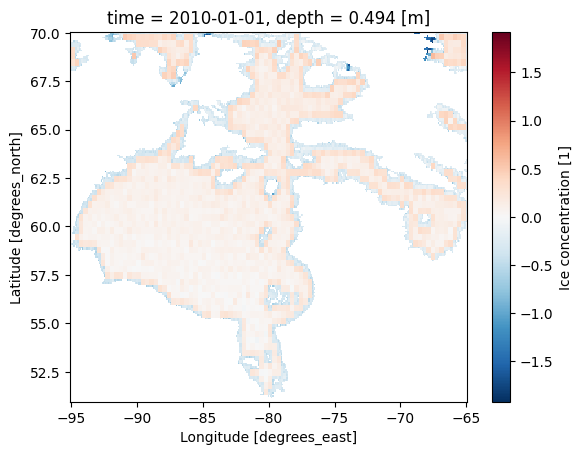

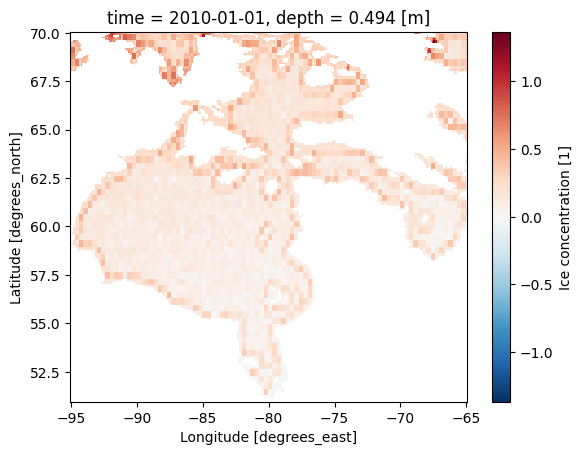

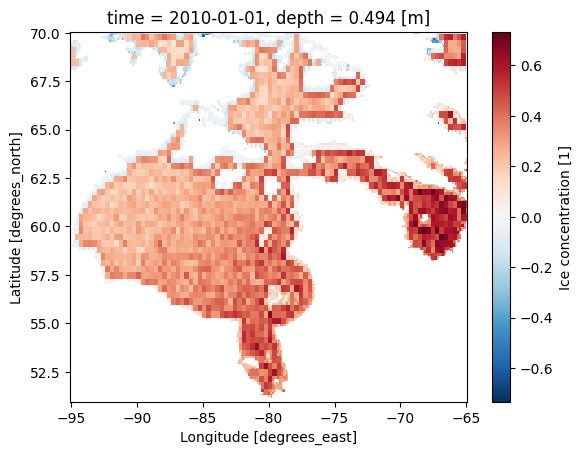

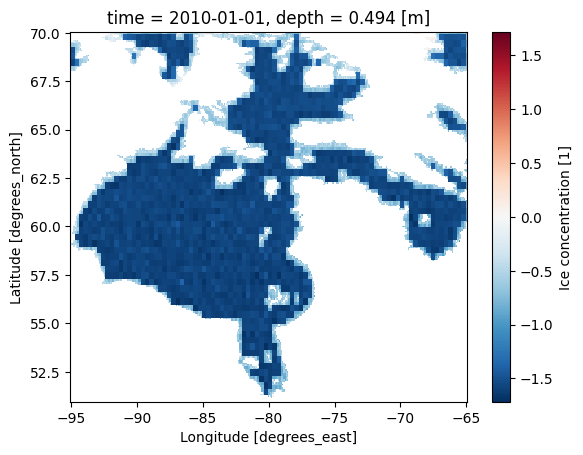

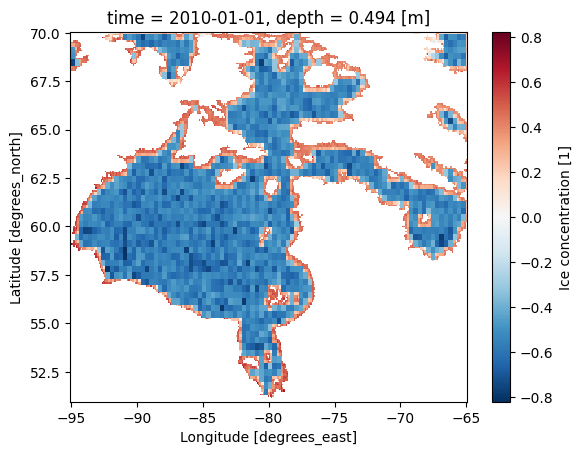

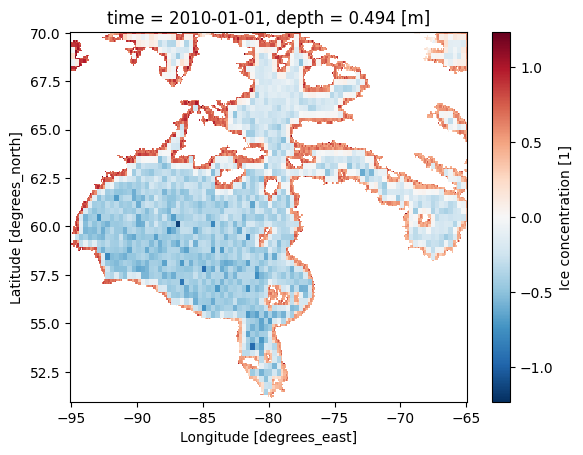

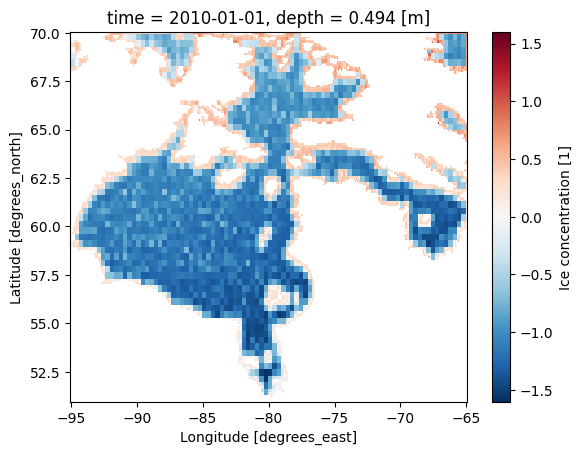

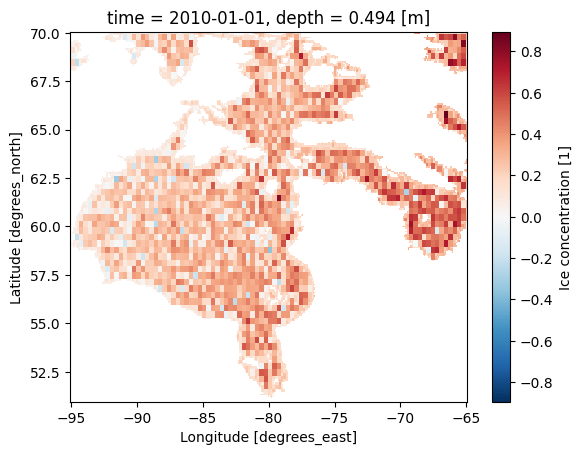

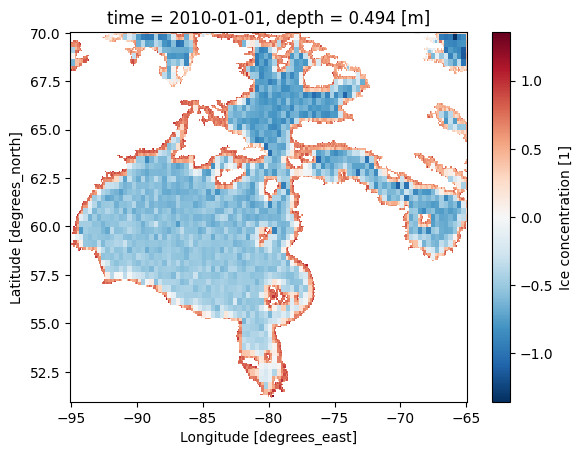

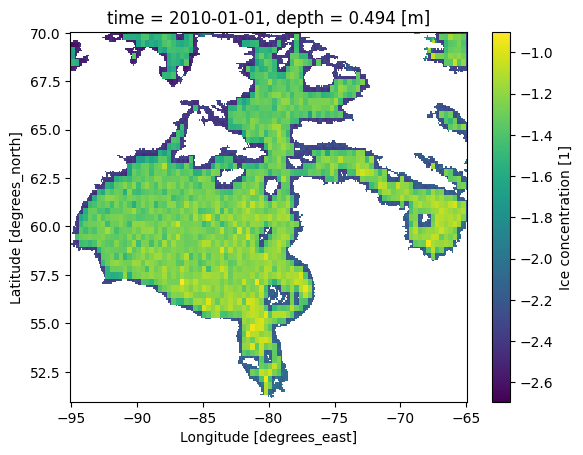

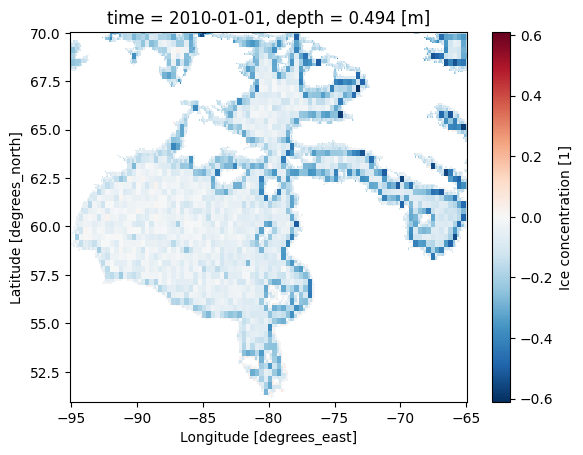

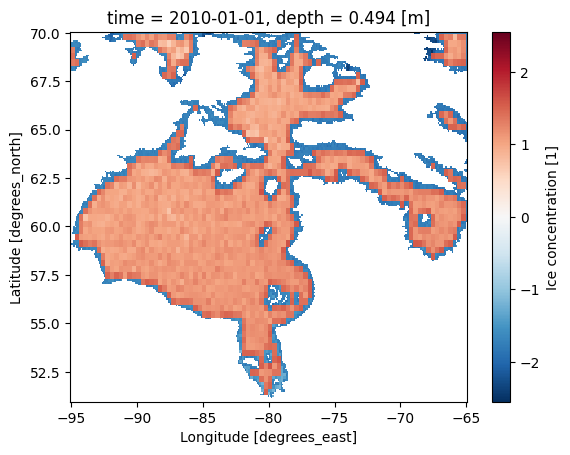

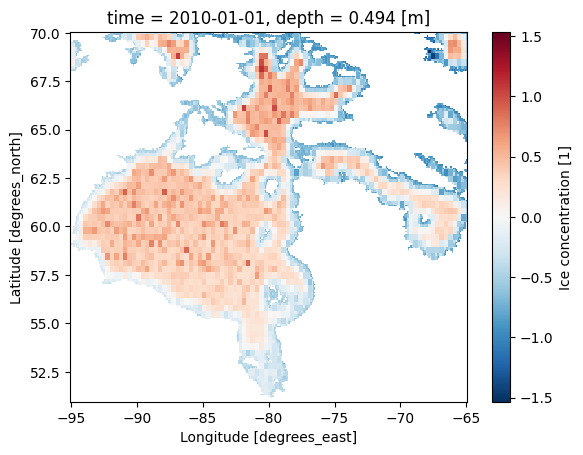

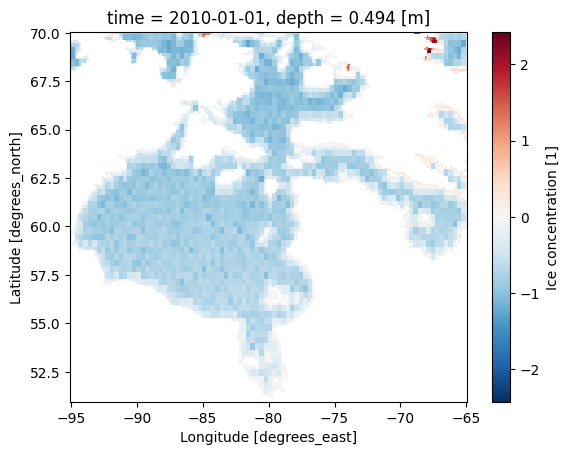

In [18]:
tmp = xr.zeros_like(ds.isel(time=0).siconc)

tmp.values = att_map[..., 0]
tmp.where(~mask).plot()
plt.show()

for i in range(x.shape[-1]):
    tmp.values = x[..., i]
    tmp.where(~mask).plot()
    plt.show()